In [304]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import seaborn as sns
import os
from sklearn.metrics import confusion_matrix

In [305]:
experiment_dir = r"C:\Users\gschmidt\BrainDecoding\outputs\exp_7_sbj_layer_channel_dropout_0.4_sched_20250408"

In [306]:
train_raw = torch.load(os.path.join(experiment_dir, "train_outputs.pt"))
val_raw = torch.load(os.path.join(experiment_dir, "val_outputs.pt"))
test_raw = torch.load(os.path.join(experiment_dir, "test_outputs.pt"))

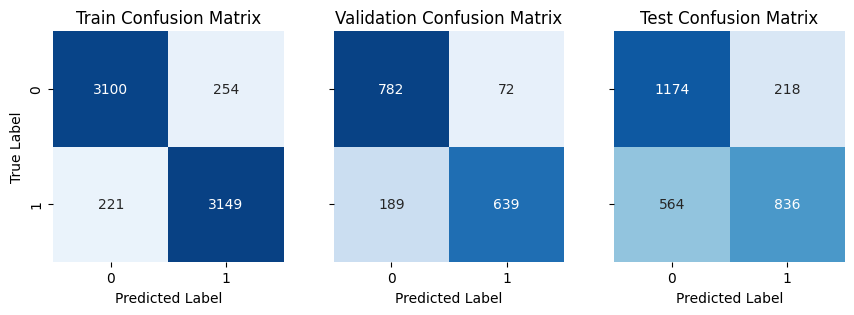

In [307]:
train_outputs, train_labels = train_raw["outputs"], train_raw["labels"]
train_pred_label = torch.argmax(train_outputs, dim=1)
outputs, labels, subjects = val_raw["outputs"], val_raw["labels"], val_raw["subjects"]
pred_label = torch.argmax(outputs, dim=1)
test_outputs, test_labels, test_subjects = test_raw["outputs"], test_raw["labels"], test_raw["subjects"]
test_pred_label = torch.argmax(test_outputs, dim=1)

cm_matrix_train = confusion_matrix(train_labels.cpu(), train_pred_label.cpu(), labels=[0, 1])
cm_matrix_val = confusion_matrix(labels.cpu(), pred_label.cpu(), labels=[0, 1])
cm_matrix_test = confusion_matrix(test_labels.cpu(), test_pred_label.cpu(), labels=[0, 1])

fig, ax = plt.subplots(1, 3, figsize=(9, 3), sharey=True)

sns.heatmap(cm_matrix_train, annot=True, fmt='d', cmap='Blues', ax=ax[0], square=True, cbar=False, vmin=0, vmax=len(train_labels)/2)
ax[0].set_title("Train Confusion Matrix")
ax[0].set_xlabel("Predicted Label")
ax[0].set_ylabel("True Label")
ax[0].set_xticklabels([0, 1])
ax[0].set_yticklabels([0, 1])

sns.heatmap(cm_matrix_val, annot=True, fmt='d', cmap='Blues', ax=ax[1], square=True, cbar=False, vmin=0, vmax=len(labels)/2)
ax[1].set_title("Validation Confusion Matrix")
ax[1].set_xlabel("Predicted Label")
ax[1].set_xticklabels([0, 1])
ax[1].set_yticklabels([0, 1])

sns.heatmap(cm_matrix_test, annot=True, fmt='d', cmap='Blues', ax=ax[2], square=True, cbar=False, vmin=0, vmax=len(test_labels)/2)
ax[2].set_title("Test Confusion Matrix")
ax[2].set_xlabel("Predicted Label")
ax[2].set_xticklabels([0, 1])
ax[2].set_yticklabels([0, 1])

plt.tight_layout()
plt.show()

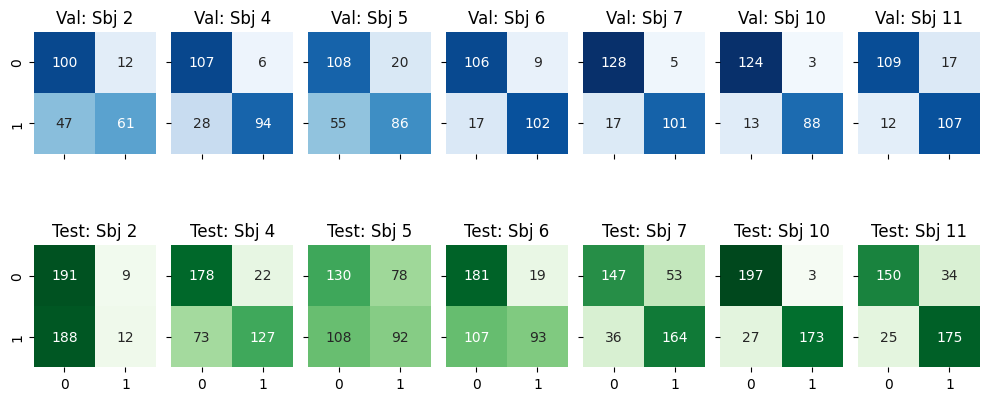

In [308]:
unique_subjects = torch.unique(subjects)

n_subjects = len(unique_subjects)


fig, axs = plt.subplots(2, n_subjects, figsize=(10, 5), sharex=True, sharey=True)
for idx, subject in enumerate(unique_subjects):
    subject_mask = (subjects == subject)

    # Training data
    subject_labels = labels[subject_mask]
    subject_preds = pred_label[subject_mask]
    cm_train = confusion_matrix(subject_labels.cpu(), subject_preds.cpu(), labels=[0, 1])

    sns.heatmap(cm_train, annot=True, fmt='d', cmap='Blues', ax=axs[0, idx], square=True, cbar=False, vmin=0, vmax=len(subject_labels)/2)
    axs[0, idx].set_title(f"Val: Sbj {subject}")
    axs[0, idx].set_xticklabels([0, 1])
    axs[0, idx].set_yticklabels([0, 1])

    # Test data
    test_mask = (test_subjects == subject)
    test_subject_labels = test_labels[test_mask]
    test_subject_preds = test_pred_label[test_mask]
    cm_test = confusion_matrix(test_subject_labels.cpu(), test_subject_preds.cpu(), labels=[0, 1])

    sns.heatmap(cm_test, annot=True, fmt='d', cmap='Greens', ax=axs[1, idx], square=True, cbar=False, vmin=0, vmax=len(test_subject_labels)/2)
    axs[1, idx].set_title(f"Test: Sbj {subject.item()}")
    axs[1, idx].set_xticklabels([0, 1])
    axs[1, idx].set_yticklabels([0, 1])

plt.tight_layout()
plt.show()

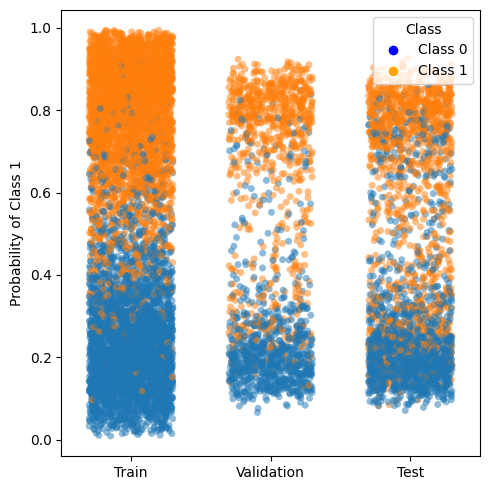

In [309]:
probs = torch.sigmoid(outputs)[:, 1]
probs_train = torch.sigmoid(train_outputs)[:, 1]
probs_test = torch.sigmoid(test_outputs)[:, 1]
fig, ax = plt.subplots(figsize=(5, 5))
sns.stripplot(x=0, y=probs_train.detach(), hue=train_labels, ax=ax, alpha=0.5, jitter=0.3)
sns.stripplot(x=1, y=probs, hue=labels, ax=ax, alpha=0.5, jitter=0.3)
sns.stripplot(x=2, y=probs_test.detach(), hue=test_labels, ax=ax, alpha=0.5, jitter=0.3)
ax.set_xticks([0, 1, 2], ["Train", "Validation", "Test"])
ax.set_ylabel("Probability of Class 1")
handles = [
    plt.Line2D([0], [0], marker='o', color='w', label='Class 0', markerfacecolor='blue', markersize=8),
    plt.Line2D([0], [0], marker='o', color='w', label='Class 1', markerfacecolor='orange', markersize=8)
]
ax.legend(handles=handles, title="Class", loc='upper right')
plt.tight_layout()
plt.show()